# MFCC / speaker prediction

In [31]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
import sqlite3


conn = sqlite3.connect("./train-clean-100.db")
cur = conn.cursor()
cur.execute('''select distinct readerID, gender from data''' )
obj = cur.fetchall()
conn.close()
print(obj)

[(103, 1), (1034, 0), (1040, 0), (1069, 1), (1081, 0), (1088, 1), (1098, 1), (1116, 1), (118, 0), (1183, 1), (1235, 0), (1246, 1), (125, 1), (1263, 1), (1334, 0), (1355, 0), (1363, 1), (1447, 1), (1455, 0), (150, 1), (1502, 1), (1553, 1), (1578, 1), (1594, 0), (1624, 0), (163, 0), (1723, 0), (1737, 1), (1743, 0), (1841, 1), (1867, 0), (1898, 1), (19, 1), (1926, 1), (196, 0), (1963, 1), (1970, 1), (198, 1), (1992, 1), (200, 1), (2002, 0), (2007, 1), (201, 0), (2092, 1), (211, 1), (2136, 0), (2159, 0), (2182, 1), (2196, 1), (226, 1), (2289, 0), (229, 0), (233, 0), (2384, 0), (2391, 1), (2416, 1), (2436, 0), (248, 1), (250, 1), (2514, 0), (2518, 0), (254, 0), (26, 0), (2691, 1), (27, 0), (2764, 1), (2817, 1), (2836, 1), (2843, 0), (289, 1), (2893, 0), (2910, 1), (2911, 0), (2952, 0), (298, 1), (2989, 1), (302, 1), (307, 0), (311, 0), (3112, 1), (3168, 0), (32, 1), (3214, 0), (322, 1), (3235, 1), (3240, 0), (3242, 0), (3259, 1), (328, 1), (332, 0), (3374, 0), (3436, 0), (3440, 1), (3486, 0

In [16]:
import collections
collections.Counter([j for i,j in obj])


Counter({0: 126, 1: 125})

In [17]:
gender_dict = {k:v for k,v in obj}

In [18]:
def load_wav(file_path):
    from scipy.io.wavfile import read

    wavfile = file_path

    fs, data = read(wavfile)

#     print("Sampling rate :", fs)
#     print("Sample num :",len(data))
    
    return fs,data

In [19]:
all_data = np.empty((0,10000), int)
# all_data = []
all_labels = []
for path in glob.glob("wav_samples/*"):
    fs,data = load_wav(path)
    all_data = np.append(all_data, np.array([data[:10000]]), axis=0)
#     all_data.append(data[:10000])
    all_labels.append(gender_dict[int(path.split("/")[1].split("-")[0])])
#     print("gen",gender_dict[int(path.split("/")[1].split("-")[0])])
#     print(data[:10])

print(all_data)
print(all_labels)
all_labels = np.array(all_labels)

[[ -213  -181  -203 ...,   610   482   326]
 [  563   573   581 ...,  1779  1603  1558]
 [   -8    -3     5 ...,  1381  1308  1443]
 ..., 
 [  -14    -7   -20 ...,  1735 -1020    33]
 [  -41   -25    -8 ...,  6018  6188  6315]
 [   17    17    -1 ...,  -206  -238  -261]]
[1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1

In [20]:
x_train = all_data[:10]
y_train = all_labels[:10]
x_test = all_data[100:105]
y_test = all_labels[100:105]

In [21]:
print(x_train.shape)

(10, 10000)


In [22]:
X_train = np.empty((0,1000),int)
Y_train = []
X_test = np.empty((0,1000),int)
Y_test = []
for j in range(10):
    for i in range(10):
        X_train = np.append(X_train,np.array([x_train[j][i:i+1000]]),axis= 0 )
        Y_train.append(y_train[j])
Y_train = np.array(Y_train)
        
for j in range(5):
    for i in range(10):
        X_test = np.append(X_test,np.array([x_test[j][i:i+1000]]),axis= 0 )
        Y_test.append(y_test[j])
Y_test = np.array(Y_test)

In [23]:
X_train = X_train.reshape(100,1000,1)
X_test = X_test.reshape(50,1000,1)

In [24]:
import wave
import numpy as np
import scipy.signal
import scipy.fftpack
import scipy.fftpack.realtransforms

def wavread(filename):
    wf = wave.open(filename, "r")
    fs = wf.getframerate()
    x = wf.readframes(wf.getnframes())
    x = np.frombuffer(x, dtype="int16") / 32768.0  # (-1, 1)に正規化
    wf.close()
    return x, float(fs)

def hz2mel(f):
    """Hzをmelに変換"""
    return 1127.01048 * np.log(f / 700.0 + 1.0)

def mel2hz(m):
    """melをhzに変換"""
    return 700.0 * (np.exp(m / 1127.01048) - 1.0)

def melFilterBank(fs, nfft, numChannels):
    """メルフィルタバンクを作成"""
    # ナイキスト周波数（Hz）
    fmax = fs / 2
    # ナイキスト周波数（mel）
    melmax = hz2mel(fmax)
    # 周波数インデックスの最大数
    nmax = nfft / 2
    # 周波数解像度（周波数インデックス1あたりのHz幅）
    df = fs / nfft
    # メル尺度における各フィルタの中心周波数を求める
    dmel = melmax / (numChannels + 1)
    melcenters = np.arange(1, numChannels + 1) * dmel
    # 各フィルタの中心周波数をHzに変換
    fcenters = mel2hz(melcenters)
    # 各フィルタの中心周波数を周波数インデックスに変換
    indexcenter = np.round(fcenters / df)
    # 各フィルタの開始位置のインデックス
    indexstart = np.hstack(([0], indexcenter[0:numChannels - 1]))
    # 各フィルタの終了位置のインデックス
    indexstop = np.hstack((indexcenter[1:numChannels], [nmax]))

    filterbank = np.zeros((numChannels, int(nmax)))
    for c in np.arange(0, numChannels):
        # 三角フィルタの左の直線の傾きから点を求める
        increment= 1.0 / (indexcenter[c] - indexstart[c])
        for i in np.arange(indexstart[c], indexcenter[c]):
            i=int(i)
            filterbank[c, i] = (i - indexstart[c]) * increment
        # 三角フィルタの右の直線の傾きから点を求める
        decrement = 1.0 / (indexstop[c] - indexcenter[c])
        for i in np.arange(indexcenter[c], indexstop[c]):
            i=int(i)
            filterbank[c, i] = 1.0 - ((i - indexcenter[c]) * decrement)

    return filterbank, fcenters

def preEmphasis(signal, p):
    """プリエンファシスフィルタ"""
    # 係数 (1.0, -p) のFIRフィルタを作成
    return scipy.signal.lfilter([1.0, -p], 1, signal)

def mfcc(signal, nfft, fs, nceps):
    """信号のMFCCパラメータを求める
    signal: 音声信号
    nfft  : FFTのサンプル数
    nceps : MFCCの次元"""
    # プリエンファシスフィルタをかける
    p = 0.97         # プリエンファシス係数
    signal = preEmphasis(signal, p)

    # ハミング窓をかける
    hammingWindow = np.hamming(len(signal))
    signal = signal * hammingWindow

    # 振幅スペクトルを求める
    spec = np.abs(np.fft.fft(signal, nfft))[:int(nfft/2)]
    fscale = np.fft.fftfreq(nfft, d = 1.0 / fs)[:int(nfft/2)]

    # メルフィルタバンクを作成
    numChannels = 20  # メルフィルタバンクのチャネル数
    df = fs / nfft   # 周波数解像度（周波数インデックス1あたりのHz幅）
    filterbank, fcenters = melFilterBank(fs, nfft, numChannels)


    # 定義通りに書いた場合
    # 振幅スペクトルに対してフィルタバンクの各フィルタをかけ、振幅の和の対数をとる
    mspec = np.log10(np.dot(spec, filterbank.T))


    # 離散コサイン変換
    ceps = scipy.fftpack.realtransforms.dct(mspec, type=2, norm="ortho", axis=-1)

    # 低次成分からnceps個の係数を返す
    return ceps[:nceps]

#wavファイルと次元数を入れてMFCCを抽出
#   nfft:FFTのサンプル数　1024, 2048, 4096
#   nceps:MFCCの次元数　大体12次元が多い
#   ※ fs * cuttime >= nfft/2 を満たす値を与えなければいけない
def get_feature(wavfile,nfft,nceps):
    # 音声をロード
    wav, fs = wavread(wavfile)
    t = np.arange(0.0, len(wav) / fs, 1/fs)
    
    # 音声波形の中心部分を切り出す
    center = len(wav) / 2  # 中心のサンプル番号
    cuttime = 0.8         # 切り出す長さ [s]
    wavdata = wav[int(center - cuttime/2*fs) : int(center + cuttime/2*fs)]
    
    ceps = mfcc(wavdata, nfft, fs, nceps)
    return ceps.tolist()

In [25]:
x_train.shape

(10, 10000)

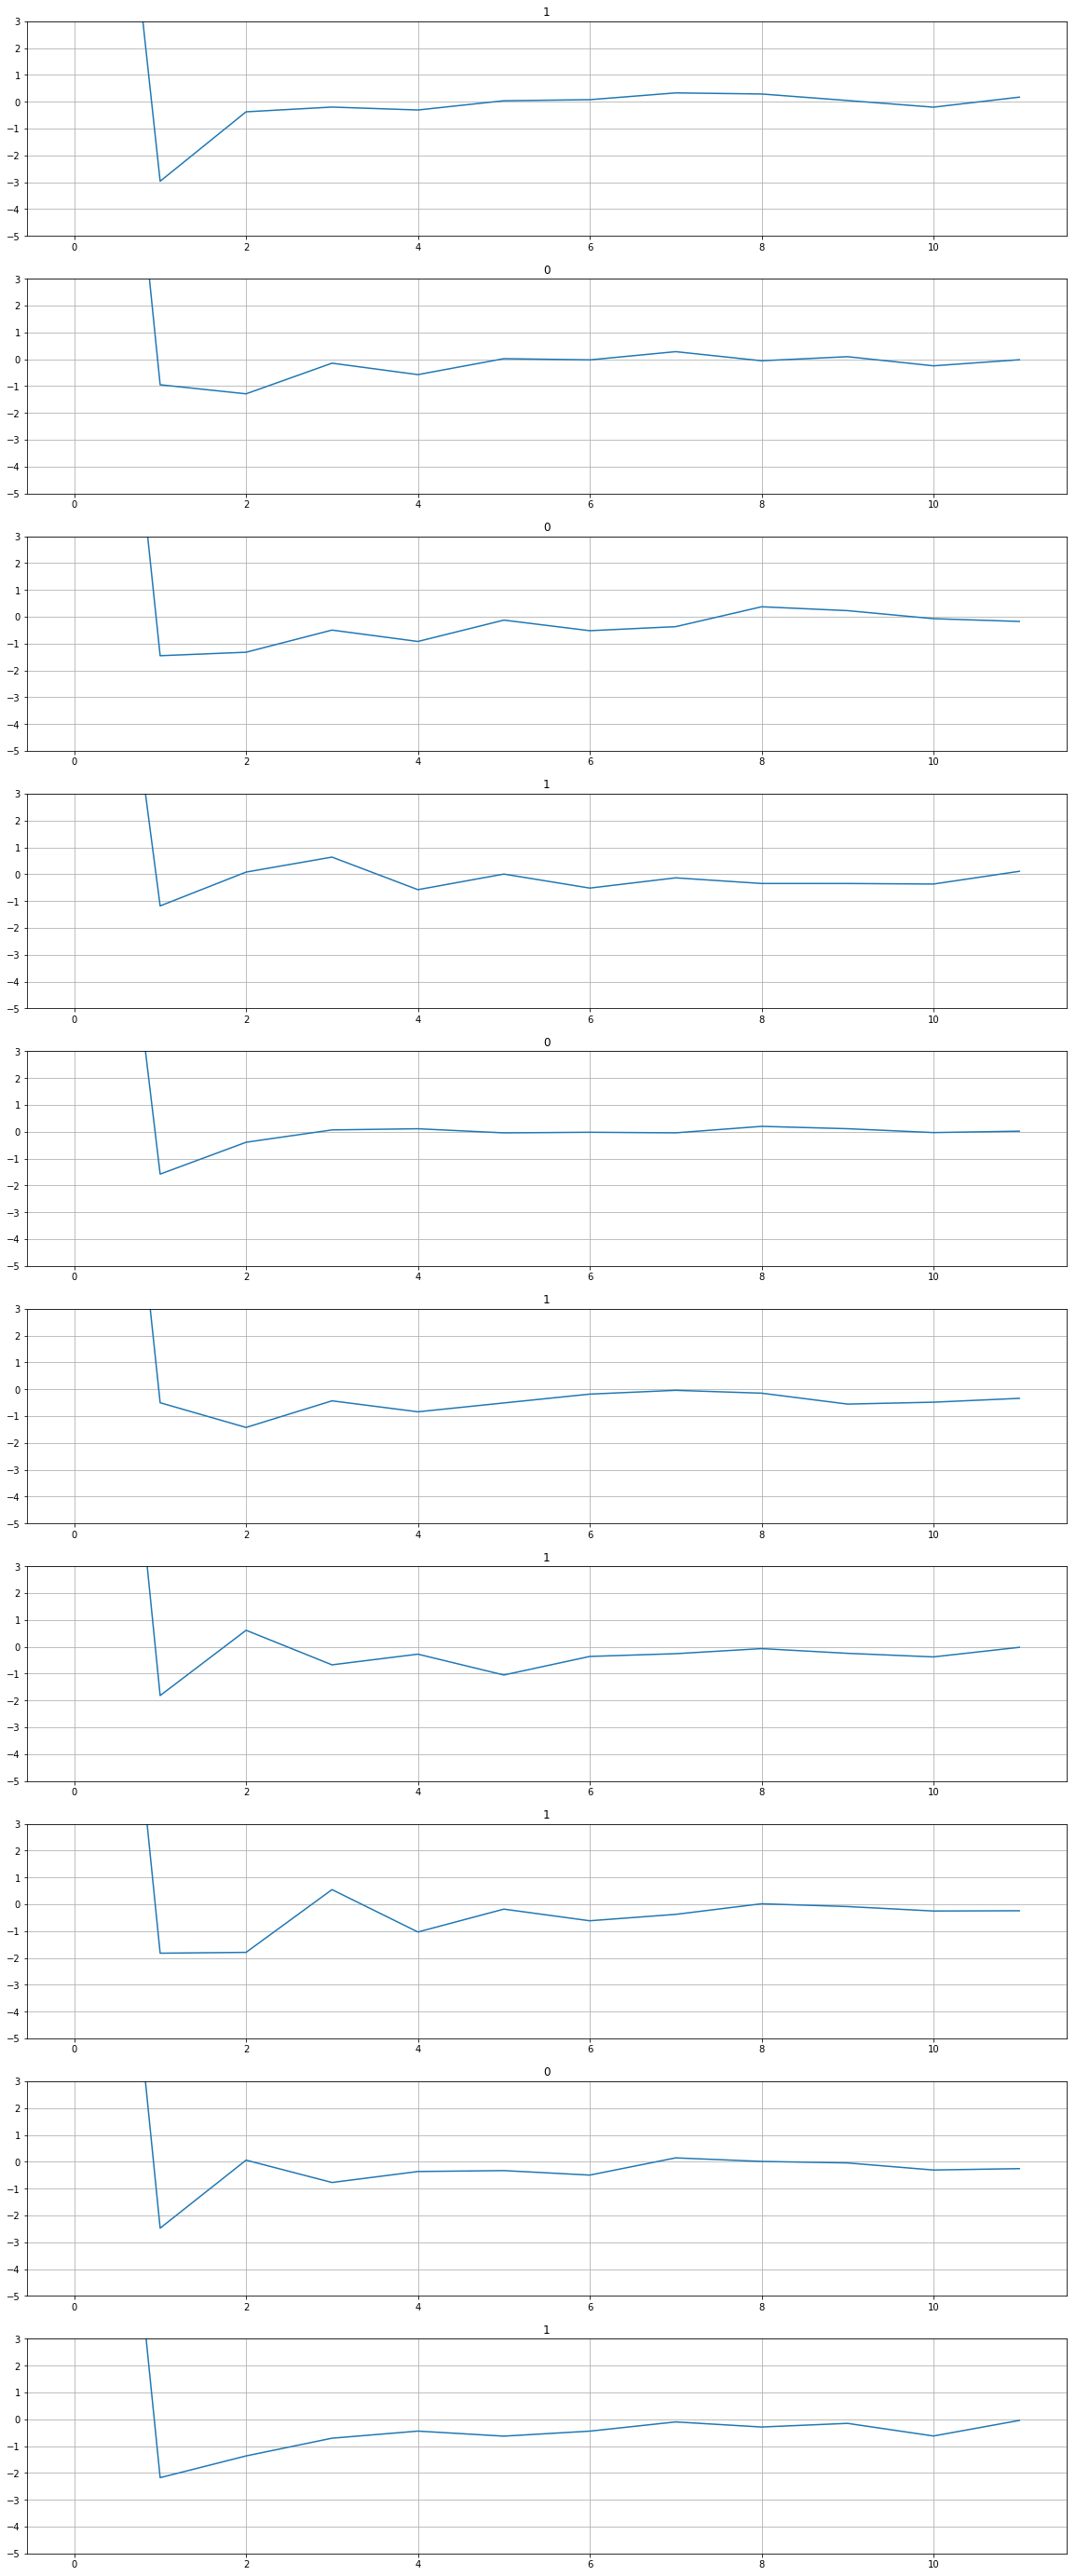

In [35]:
fig = plt.figure(figsize=(20,50))
for i in range(10):
    melbank = mfcc(x_train[i], len(x_train[i]),16200, 12)
    
    fig.add_subplot(10,1,i+1)
    plt.plot(melbank)
    plt.ylim(-5,3)
    plt.grid()
    plt.title(y_train[i])
plt.show()